# 量化策略回测框架 (仅已实现盈亏版本 - 最终修正版)

In [11]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style, Back
from sklearn.preprocessing import StandardScaler
import pickle
from pathlib import Path
import warnings
from collections import deque

warnings.filterwarnings('ignore', category=UserWarning)

---
## 1. 日志和绘图设置

In [12]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # 使用更美观的绘图风格

---
## 2. 核心回测与评估函数

In [13]:
def run_realized_pnl_backtest(prices, signals, initial_capital=100000, commission_rate=0.0002, holding_period=10):
    """
    执行基于已实现盈亏的回测，资金等分成10份，避免重复计算手续费
    收到反向信号时只平掉最早的一份持仓，而不是全部平仓!
    
    核心逻辑:
    1. 初始资金分成10等份, 每份独立管理
    2. 在任何时刻只能持有一个方向的仓位（全多头或全空头）
    3. 信号在t时刻产生, 在t+1时刻执行
    4. 当收到相反方向的信号时, 只平掉最早的一份持仓
    5. 每份仓位最多持有holding_period个周期, 到期自动平仓
    6. 权益曲线完全基于已实现盈亏计算，忽略浮动盈亏
    
    参数:
    - prices (pd.Series): 'close'价格序列
    - signals (pd.Series): 交易信号序列 (1 for long, -1 for short, 0 for neutral)
    - initial_capital (float): 初始资金
    - commission_rate (float): 单边交易手续费率
    - holding_period (int): 每笔交易的固定持有周期
    
    返回:
    - pd.DataFrame: 包含回测详细过程的DataFrame
    - pd.DataFrame: 交易历史记录
    """
    logging.info("🤔 开始执行基于已实现盈亏的回测...")
    
    # 复制数据以避免修改原始数据
    df = pd.DataFrame({
        'close': prices,
        'signal': signals
    }).copy()
    
    # 初始化结果列
    df['position'] = 0.0                  # 当前持仓方向 (1: 多, -1: 空, 0: 无)
    df['position_count'] = 0              # 当前持仓份数
    df['cost_basis'] = 0.0                # 当前持仓成本价
    df['transaction_costs'] = 0.0         # 交易成本
    df['net_returns'] = 0.0               # 净收益
    df['equity_curve'] = initial_capital  # 资金曲线（仅基于已实现盈亏）
    
    # 初始化持仓管理
    active_positions = deque()  # 使用deque作为先进先出队列
    realized_pnl = 0.0          # 累计已实现盈亏
    position_direction = 0      # 当前持仓方向
    position_cost = 0.0         # 当前持仓平均成本
    
    # 交易记录
    trade_history = []
    
    # 资金分成10份
    capital_per_position = initial_capital / 10
    
    # 当前权益（仅基于已实现盈亏）
    current_equity = initial_capital
    
    # 遍历每个时间点
    for i in range(1, len(df)):
        current_close = df['close'].iloc[i]
        prev_signal = df['signal'].iloc[i-1]  # 使用前一个信号决定当前操作
        
        # 记录是否有交易发生
        trades_occurred = False
        
        # 1. 处理到期仓位
        positions_to_remove = []
        for pos in list(active_positions):  # 使用list避免在遍历时修改队列
            # 检查仓位是否到期
            if i - pos['entry_index'] >= holding_period:
                # 计算盈亏
                exit_price = current_close
                direction = pos['direction']
                quantity = pos['quantity']
                entry_price = pos['entry_price']
                
                # 计算盈亏和手续费
                pnl = (exit_price - entry_price) * direction * quantity
                exit_commission = commission_rate * exit_price * quantity
                net_pnl = pnl - exit_commission
                
                # 更新累计已实现盈亏
                realized_pnl += net_pnl
                trades_occurred = True
                
                # 记录交易成本
                df.at[df.index[i], 'transaction_costs'] += exit_commission
                
                # 记录交易历史
                trade_history.append({
                    'entry_time': df.index[pos['entry_index']],
                    'exit_time': df.index[i],
                    'direction': direction,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'quantity': quantity,
                    'pnl': pnl,
                    'commission': exit_commission,
                    'net_pnl': net_pnl,
                    'duration': i - pos['entry_index'],
                    'type': 'expired'
                })
                
                # 标记为需要移除
                positions_to_remove.append(pos)
        
        # 移除到期仓位
        for pos in positions_to_remove:
            active_positions.remove(pos)
        
        # 2. 处理新信号
        if prev_signal != 0:  # 忽略中性信号
            # 情况1: 当前无持仓
            if position_direction == 0:
                # 开新仓
                entry_price = current_close
                quantity = capital_per_position / entry_price
                
                new_position = {
                    'direction': prev_signal,
                    'entry_price': entry_price,
                    'quantity': quantity,
                    'entry_index': i
                }
                active_positions.append(new_position)
                
                # 更新持仓信息
                position_direction = prev_signal
                position_cost = entry_price
                
                # 计算开仓手续费
                entry_commission = commission_rate * entry_price * quantity
                df.at[df.index[i], 'transaction_costs'] += entry_commission
                
                # 记录仓位变化
                df.at[df.index[i], 'position'] = prev_signal
            
            # 情况2: 当前有持仓且新信号方向相同
            elif position_direction == prev_signal:
                # 检查是否还有可用仓位 (最多10份)
                if len(active_positions) < 10:
                    # 开新仓
                    entry_price = current_close
                    quantity = capital_per_position / entry_price
                    
                    new_position = {
                        'direction': prev_signal,
                        'entry_price': entry_price,
                        'quantity': quantity,
                        'entry_index': i
                    }
                    active_positions.append(new_position)
                    
                    # 更新平均成本
                    total_quantity = sum(pos['quantity'] for pos in active_positions)
                    position_cost = sum(pos['entry_price'] * pos['quantity'] for pos in active_positions) / total_quantity
                    
                    # 计算开仓手续费
                    entry_commission = commission_rate * entry_price * quantity
                    df.at[df.index[i], 'transaction_costs'] += entry_commission
                    
                    # 记录仓位变化
                    df.at[df.index[i], 'position'] = prev_signal
            
            # 情况3: 当前有持仓且新信号方向相反
            else:
                # 只平掉最早的一份持仓
                if active_positions:
                    # 获取最早的开仓
                    oldest_position = active_positions.popleft()
                    
                    # 平仓操作
                    exit_price = current_close
                    direction = oldest_position['direction']
                    quantity = oldest_position['quantity']
                    entry_price = oldest_position['entry_price']
                    
                    # 计算盈亏和手续费
                    pnl = (exit_price - entry_price) * direction * quantity
                    exit_commission = commission_rate * exit_price * quantity
                    net_pnl = pnl - exit_commission
                    
                    # 更新累计已实现盈亏
                    realized_pnl += net_pnl
                    trades_occurred = True
                    
                    # 记录交易成本
                    df.at[df.index[i], 'transaction_costs'] += exit_commission
                    
                    # 记录交易历史
                    trade_history.append({
                        'entry_time': df.index[oldest_position['entry_index']],
                        'exit_time': df.index[i],
                        'direction': direction,
                        'entry_price': entry_price,
                        'exit_price': exit_price,
                        'quantity': quantity,
                        'pnl': pnl,
                        'commission': exit_commission,
                        'net_pnl': net_pnl,
                        'duration': i - oldest_position['entry_index'],
                        'type': 'signal'
                    })
                    
                    # 检查是否还有剩余持仓
                    if active_positions:
                        # 更新平均成本
                        total_quantity = sum(pos['quantity'] for pos in active_positions)
                        position_cost = sum(pos['entry_price'] * pos['quantity'] for pos in active_positions) / total_quantity
                    else:
                        # 没有持仓了
                        position_direction = 0
                        position_cost = 0.0
                    
                    # 记录仓位变化
                    df.at[df.index[i], 'position'] = position_direction
        
        # 更新当前持仓状态
        df.at[df.index[i], 'position_count'] = len(active_positions)
        df.at[df.index[i], 'cost_basis'] = position_cost
        
        # 更新权益曲线（基于已实现盈亏）
        current_equity = initial_capital + realized_pnl
        df.at[df.index[i], 'equity_curve'] = current_equity
        
        # 计算当日净收益率（仅在有交易发生时）
        if i > 1:
            prev_equity = df.at[df.index[i-1], 'equity_curve']
            # 仅在有交易发生时计算收益率
            if trades_occurred:
                df.at[df.index[i], 'net_returns'] = (current_equity - prev_equity) / prev_equity
            else:
                df.at[df.index[i], 'net_returns'] = 0.0
        else:
            # 第一天的处理
            if trades_occurred:
                df.at[df.index[i], 'net_returns'] = (current_equity - initial_capital) / initial_capital
            else:
                df.at[df.index[i], 'net_returns'] = 0.0
    
    # 处理回测结束时的未平仓仓位
    if active_positions:
        last_close = df['close'].iloc[-1]
        for pos in active_positions:
            exit_price = last_close
            direction = pos['direction']
            quantity = pos['quantity']
            entry_price = pos['entry_price']
            
            # 计算盈亏和手续费
            pnl = (exit_price - entry_price) * direction * quantity
            exit_commission = commission_rate * exit_price * quantity
            net_pnl = pnl - exit_commission
            
            # 更新累计已实现盈亏
            realized_pnl += net_pnl
            
            # 记录交易成本
            df.at[df.index[-1], 'transaction_costs'] += exit_commission
            
            # 记录交易历史
            trade_history.append({
                'entry_time': df.index[pos['entry_index']],
                'exit_time': df.index[-1],
                'direction': direction,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'quantity': quantity,
                'pnl': pnl,
                'commission': exit_commission,
                'net_pnl': net_pnl,
                'duration': len(df) - 1 - pos['entry_index'],
                'type': 'forced_close'
            })
        
        # 更新最终资金曲线
        current_equity = initial_capital + realized_pnl
        df.at[df.index[-1], 'equity_curve'] = current_equity
        prev_equity = df.at[df.index[-2], 'equity_curve'] if len(df) > 1 else initial_capital
        df.at[df.index[-1], 'net_returns'] = (current_equity - prev_equity) / prev_equity
    
    logging.info("🎉 基于已实现盈亏的回测完成")
    return df, pd.DataFrame(trade_history)

In [14]:
def evaluate_realized_pnl_performance(backtest_results, trade_history, initial_capital):
    """
    评估基于已实现盈亏的策略表现
    """
    logging.info("🤔 开始评估策略表现...")
    
    # 提取结果
    df = backtest_results.copy()
    trade_df = trade_history.copy()
    
    # 计算关键指标
    final_equity = df['equity_curve'].iloc[-1]
    total_return = (final_equity - initial_capital) / initial_capital
    
    # 计算回撤（仅基于已实现盈亏）
    equity_curve = df['equity_curve']
    peak = equity_curve.expanding(min_periods=1).max()
    drawdown = (peak - equity_curve) / peak
    max_drawdown = drawdown.max()
    
    # 找到最大回撤的开始和结束时间
    mdd_end = drawdown.idxmax()
    mdd_start = peak[:mdd_end].idxmax()
    
    # 计算年化收益率
    total_days = (df.index[-1] - df.index[0]).days
    duration_years = total_days / 365.25
    annualized_return = total_return / duration_years if duration_years > 0 else 0
    
    # 计算年化波动率
    daily_returns = df['equity_curve'].pct_change().fillna(0)
    annualized_volatility = daily_returns.std() * np.sqrt(365.25)
    
    # ================== 使用月度收益率计算风险指标 ==================
    # 将15分钟收益率重采样为月度收益率
    monthly_returns = df['equity_curve'].resample('M').last().pct_change().dropna()
    
    if len(monthly_returns) > 1:
        sharpe_ratio = monthly_returns.mean() / monthly_returns.std() * np.sqrt(12)
    else:
        sharpe_ratio = 0
    
    # 计算卡玛比率
    calmar_ratio = annualized_return / max_drawdown if max_drawdown > 0 else 0
    
    # ================== 交易统计 ==================
    # 计算交易指标
    total_trades = len(trade_df)
    winning_trades = trade_df[trade_df['net_pnl'] > 0]
    losing_trades = trade_df[trade_df['net_pnl'] <= 0]
    
    win_rate = len(winning_trades) / total_trades if total_trades > 0 else 0
    avg_win = winning_trades['net_pnl'].mean() / initial_capital if not winning_trades.empty else 0
    avg_loss = losing_trades['net_pnl'].mean() / initial_capital if not losing_trades.empty else 0
    
    # 盈亏比
    profit_factor = abs(winning_trades['net_pnl'].sum() / losing_trades['net_pnl'].abs().sum()) if not losing_trades.empty else float('inf')
    
    # 期望收益
    expectancy = (win_rate * avg_win) + ((1 - win_rate) * avg_loss)
    
    # 计算每周开仓频率
    weekly_trades = trade_df.resample('W', on='entry_time').size().mean() if not trade_df.empty else 0
    
    # 计算持仓占比
    long_positions = df[df['position'] > 0]
    short_positions = df[df['position'] < 0]
    long_ratio = len(long_positions) / len(df) if len(df) > 0 else 0
    short_ratio = len(short_positions) / len(df) if len(df) > 0 else 0
    
    # 计算年化换手率
    trade_df['entry_notional'] = trade_df['entry_price'] * trade_df['quantity']
    trade_df['exit_notional'] = trade_df['exit_price'] * trade_df['quantity']
    total_turnover = (trade_df['entry_notional'].sum() + trade_df['exit_notional'].sum()) / 2
    avg_net_assets = df['equity_curve'].mean()
    annualized_turnover = (total_turnover / avg_net_assets) / duration_years
    
    # === 新增指标：信息系数 ===
    forward_returns = df['close'].pct_change().shift(-1)
    valid_idx = df['signal'].shift(1).notna() & forward_returns.notna()
    ic = np.corrcoef(df['signal'].shift(1)[valid_idx], forward_returns[valid_idx])[0,1]
    
    # 计算逐年收益率
    yearly_returns = []
    for year, group in df.groupby(df.index.year):
        if len(group) > 1:
            start_equity = group['equity_curve'].iloc[0]
            end_equity = group['equity_curve'].iloc[-1]
            yearly_return = (end_equity - start_equity) / start_equity
            yearly_returns.append((year, yearly_return))
    
    # ================== 修改点 1: 修正理论基准的计算方式 ==================
    # 理论收益 = 信号方向 * (10期后的价格 - 当前价格) / 当前价格
    future_return = (df['close'].shift(-10) - df['close']) / df['close']
    theoretical_benchmark = (df['signal'].shift(1) * future_return * 0.1).fillna(0).cumsum()
    
    strategy_cumulative = (df['equity_curve'] - initial_capital) / initial_capital
    correlation = strategy_cumulative.corr(theoretical_benchmark)
    
    # ================== 打印完整报告 ==================
    print("\n" + "=" * 80)
    print(Fore.CYAN + Style.BRIGHT + " " * 30 + "策略性能评估报告" + " " * 30 + Style.RESET_ALL)
    print("=" * 80)
    
    # 收益指标表格
    print("\n" + Fore.BLUE + Style.BRIGHT + "="*30 + " 收益指标 " + "="*30 + Style.RESET_ALL)
    detail_headers = ["指标名称", "计算结果", "要求", "状态"]
    
    # 评估指标状态
    sharpe_status = "✅ 达标" if sharpe_ratio >= 2.0 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    calmar_status = "✅ 达标" if calmar_ratio >= 5.0 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    expectancy_status = "✅ 达标" if expectancy >= 0.25 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    
    detail_table = [
        ["夏普比率 (Sharpe)", f"{sharpe_ratio:.3%}", "> 2.0", sharpe_status],
        ["卡玛比率 (Calmar)", f"{calmar_ratio:.3%}", "> 5.0", calmar_status],
        ["期望收益 (Expectancy)", f"{expectancy:.4f}", "> 0.25", expectancy_status]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    # 策略方案状态
    print("\n" + Fore.BLUE + Style.BRIGHT + "策略方案评估" + Style.RESET_ALL)
    scheme_table = [
        ["方案一 (夏普 & 卡玛)", "✅ 达标" if sharpe_ratio >= 2.0 and calmar_ratio >= 5.0 else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["方案二 (期望收益)", "✅ 达标" if expectancy >= 0.25 else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合收益指标", "✅ 达标" if sharpe_ratio >= 2.0 and calmar_ratio >= 5.0 and expectancy >= 0.25 else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print(tabulate(scheme_table, headers=["策略方案", "状态"], tablefmt="grid", stralign="center", numalign="center"))
    
    # 持仓统计
    print("\n" + Fore.BLUE + Style.BRIGHT + "持仓统计" + Style.RESET_ALL)
    position_table = [
        ["多头持仓占比", f"{long_ratio:.2%}"],
        ["空头持仓占比", f"{short_ratio:.2%}"]
    ]
    print(tabulate(position_table, headers=["指标", "值"], tablefmt="grid", stralign="center", numalign="center"))
    
    # 风控与效率指标
    print("\n" + Fore.YELLOW + Style.BRIGHT + "="*30 + " 风控与效率指标 " + "="*30 + Style.RESET_ALL)
    risk_headers = ["指标名称", "计算结果", "要求", "状态"]
    mdd_status = "✅ 达标" if max_drawdown < 0.2 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    trade_freq_status = "✅ 达标" if weekly_trades > 5 else Fore.RED + "❌ 未达标" + Style.RESET_ALL
    
    risk_table = [
        ["最大回撤 (MDD)", f"{max_drawdown:.3%}", "< 0.2", mdd_status],
        ["每周开仓频率", f"{weekly_trades:.4f}", "> 5", trade_freq_status]
    ]
    print(tabulate(risk_table, headers=risk_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    # 综合指标状态
    print("\n" + Fore.YELLOW + Style.BRIGHT + "综合指标评估" + Style.RESET_ALL)
    risk_summary_table = [
        ["综合风控指标", "✅ 达标" if max_drawdown < 0.2 else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合效率指标", "✅ 达标" if weekly_trades > 5 else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print(tabulate(risk_summary_table, headers=["指标", "状态"], tablefmt="grid", stralign="center", numalign="center"))
    
    # 详细指标
    print("\n" + Fore.GREEN + Style.BRIGHT + "="*30 + " 详细指标 " + "="*30 + Style.RESET_ALL)
    detailed_headers = ["指标名称", "值"]
    detailed_table = [
        [Fore.YELLOW + "与'signal × return'基准的相关性" + Style.RESET_ALL, f"{correlation:.3%}"],
        ["总收益率 (Total Return)", f"{total_return:.3%}"],
        ["年化收益率 (Annualized Return)", f"{annualized_return:.3%}"],
        ["年化波动率 (Annualized Vol)", f"{annualized_volatility:.3%}"],
        ["总盈亏 (Total PnL)", f"${final_equity - initial_capital:,.2f}"],
        ["总交易笔数 (Total Trades)", f"{total_trades}"],
        ["盈利交易笔数 (Winning Trades)", f"{len(winning_trades)}"],
        ["亏损交易笔数 (Losing Trades)", f"{len(losing_trades)}"],
        ["胜率 (Win Rate)", f"{win_rate:.3%}"],
        ["盈亏比 (Profit Factor)", f"{profit_factor:.3%}"],
        ["平均盈利 (Average Win)", f"{avg_win:.3%}"],
        ["平均亏损 (Average Loss)", f"{avg_loss:.3%}"],
        ["年化换手率 (Annualized Turnover)", f"{annualized_turnover:.3%}"],
        ["最大回撤起始日期", f"{mdd_start}"],
        ["最大回撤结束日期", f"{mdd_end}"],
        ["信息系数 (IC)", f"{ic:.3f}"]
    ]
    print(tabulate(detailed_table, headers=detailed_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    # 逐年收益率
    print("\n" + Fore.MAGENTA + Style.BRIGHT + "="*30 + " 逐年收益率 " + "="*30 + Style.RESET_ALL)
    yearly_table = []
    for year, return_val in yearly_returns:
        yearly_table.append([year, f"{return_val:.3%}"])
    print(tabulate(yearly_table, headers=["年份", "收益率"], tablefmt="grid", stralign="center", numalign="center"))
        
    # 绘制权益曲线（阶梯状）
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # 仅在有交易发生时绘制垂直线条
    trade_dates = trade_df['exit_time'].unique()
    trade_dates = sorted(trade_dates)
    
    # 绘制阶梯状的策略权益曲线
    prev_equity = initial_capital
    for date in trade_dates:
        equity = df.loc[date, 'equity_curve']
        # 绘制水平线（前一点到当前点）
        prev_date = df.index[df.index.get_loc(date) - 1] if date != df.index[0] else date
        ax.hlines(y=prev_equity, xmin=prev_date, xmax=date, color='royalblue', linewidth=2)
        # 绘制垂直线（当前点）
        ax.vlines(x=date, ymin=prev_equity, ymax=equity, color='royalblue', linewidth=2)
        prev_equity = equity
    
    # 绘制最后一段
    last_trade_date = trade_dates[-1] if trade_dates else df.index[0]
    ax.hlines(y=prev_equity, xmin=last_trade_date, xmax=df.index[-1], color='royalblue', linewidth=2)
    
    # 绘制策略权益曲线主线（阶梯状）
    ax.step(df.index, df['equity_curve'], where='post', label='Strategy Equity (Realized PnL)', color='royalblue', linewidth=2)
    
    # 理论基准曲线
    theoretical_curve = initial_capital * (1 + theoretical_benchmark)
    ax.plot(df.index, theoretical_curve, label='Theoretical Benchmark (signal×return)', color='purple', linestyle='--', alpha=0.7)
    
    # ================== 修改点 2: 修正买入持有曲线的计算方式 ==================
    # 采用与收盘价同步的单利模式，并归一化到初始资本
    buy_hold_curve = initial_capital * (df['close'] / df['close'].iloc[0])
    ax.plot(df.index, buy_hold_curve, label='Buy & Hold BTC', color='darkorange', linestyle=':', alpha=0.7)

    # 设置标题和标签
    ax.set_title('Strategy Equity Curve vs. Benchmarks (Realized PnL Only)', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Net Asset Value', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

---
## 3. 主程序执行

2025-07-28 14:00:57,184 - INFO - 正在从 /public/data/_test_backtest_intern.pkl 加载数据...
2025-07-28 14:00:57,192 - INFO - 数据加载成功。
2025-07-28 14:00:57,192 - INFO - 🤔 开始执行基于已实现盈亏的回测...
2025-07-28 14:01:22,539 - INFO - 🎉 基于已实现盈亏的回测完成
2025-07-28 14:01:22,590 - INFO - 🤔 开始评估策略表现...



                              策略性能评估报告                              

============================== 收益指标 ==============================
+-----------------------+------------+--------+-----------+
|       指标名称        |  计算结果  |  要求  |   状态    |
+=======================+============+========+===========+
|   夏普比率 (Sharpe)   |  46.161%   | > 2.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
|   卡玛比率 (Calmar)   |  19.717%   | > 5.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
| 期望收益 (Expectancy) |   0.0000   | > 0.25 | ❌ 未达标 |
+-----------------------+------------+--------+-----------+

策略方案评估
+----------------------+-----------+
|       策略方案       |   状态    |
+======================+===========+
| 方案一 (夏普 & 卡玛) | ❌ 未达标 |
+----------------------+-----------+
|  方案二 (期望收益)   | ❌ 未达标 |
+----------------------+-----------+
|     综合收益指标     | ❌ 未达标 |
+----------------------+-----------+

持仓统计
+--------------+-------+
|     指标     |  值   |
+=

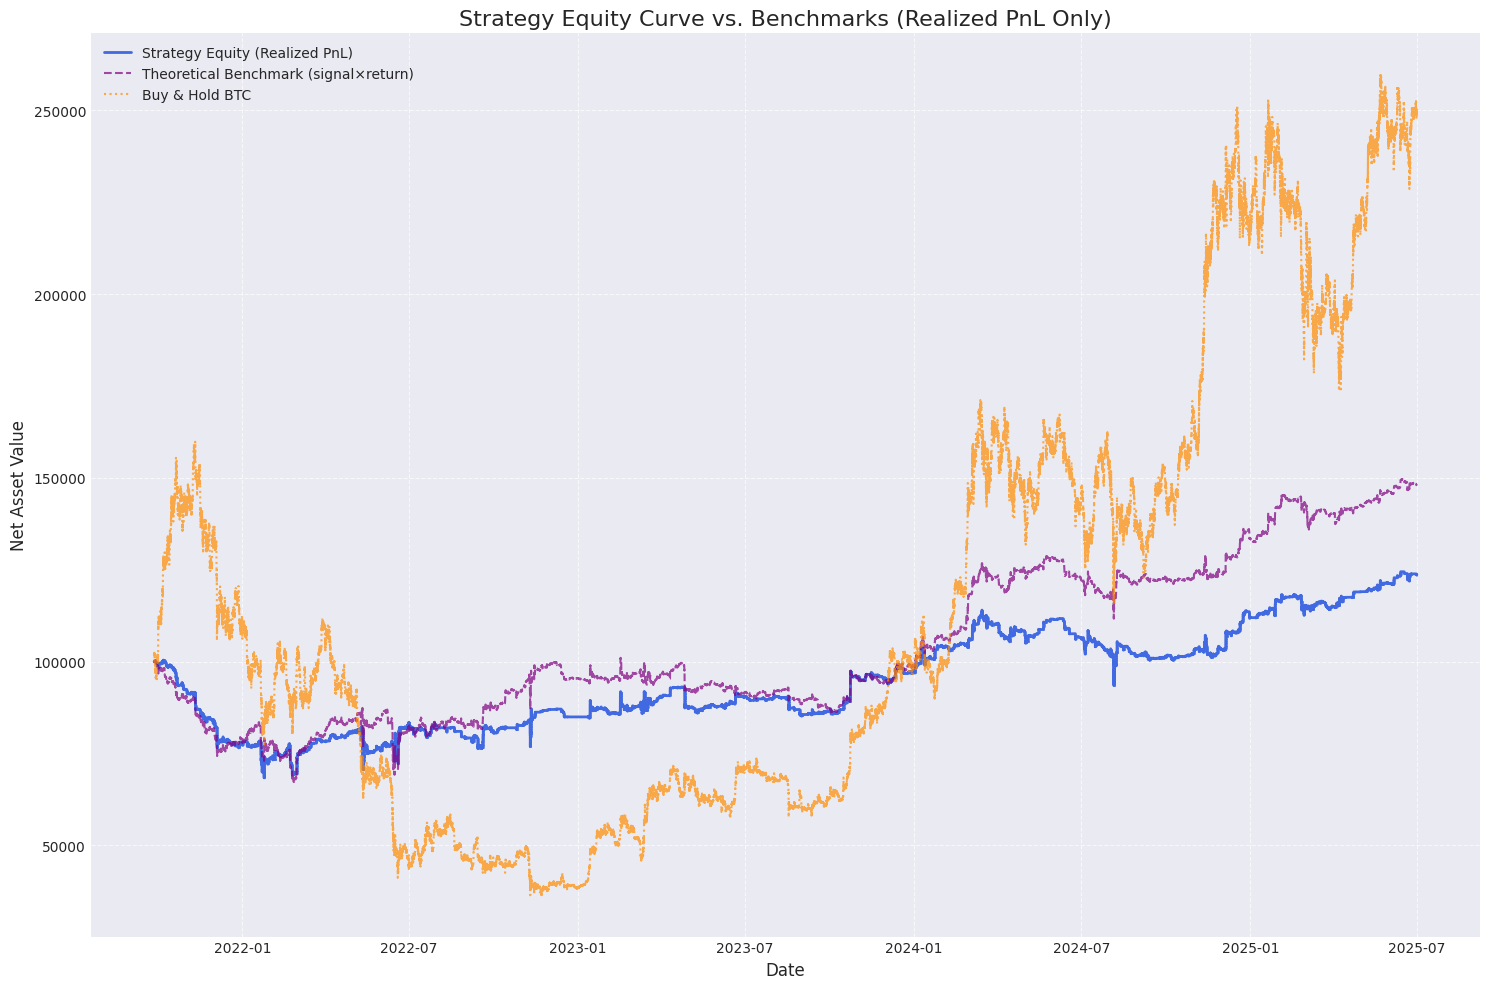

In [15]:
if __name__ == '__main__':
    # --- 1. 参数配置 ---
    # 文件路径
    FILE_PATH = "/public/data/_test_backtest_intern.pkl"
    
    # 回测参数
    COMMISSION_RATE = 0.0002     # 单边手续费
    INITIAL_CAPITAL = 100000     # 初始资金
    HOLDING_PERIOD = 10          # 固定持有10个15分钟bar
    
    # --- 2. 数据加载 ---
    logging.info(f"正在从 {FILE_PATH} 加载数据...")
    
    try:
        file_path = Path(FILE_PATH)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # 确保索引是datetime类型
        data.index = pd.to_datetime(data.index)
        data = data.rename_axis('open_time')

        logging.info("数据加载成功。")

    except FileNotFoundError:
        logging.error(f"错误: 数据文件未找到于路径 {FILE_PATH}")
        data = None
    except Exception as e:
        logging.error(f"加载数据时发生错误: {e}")
        data = None

    # --- 3. 执行回测 (使用基于已实现盈亏的策略) ---
    if data is not None:
        backtest_results, trade_history = run_realized_pnl_backtest(
            prices=data['close'],
            signals=data['signal'],
            initial_capital=INITIAL_CAPITAL,
            commission_rate=COMMISSION_RATE,
            holding_period=HOLDING_PERIOD
        )

        # --- 4. 性能评估 ---
        evaluate_realized_pnl_performance(
            backtest_results, 
            trade_history,
            INITIAL_CAPITAL
        )
    else:
        logging.warning("由于数据加载失败, 回测和评估步骤已跳过。")